<img src="https://devra.ai/analyst/notebook/1648/image.jpg" style="width: 100%; height: auto;" />

<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background: #2E0249; background: #11001C; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;">  <div style="font-size:150%; color:#FEE100"><b>Fraud Detection in Transactions Analysis Notebook</b></div>  <div>This notebook was created with the help of <a href="https://devra.ai/ref/kaggle" style="color:#6666FF">Devra AI</a></div></div>

## Table of Contents
- [Introduction](#Introduction)
- [Imports and Setup](#Imports-and-Setup)
- [Data Loading](#Data-Loading)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Predictor Development and Evaluation](#Predictor-Development-and-Evaluation)
- [Conclusion](#Conclusion)

## Introduction

Fraudulent transactions never fail to surprise, especially when patterns emerge where least expected. In this notebook, we explore a dataset containing transaction data to unearth hidden signals of fraud. The following workflow is designed to offer insights through robust visualization and modeling approaches. If you find this notebook useful, please consider upvoting it as a sign of appreciation.

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import libraries
import numpy as np
import pandas as pd
import matplotlib
# If only plt is imported, switch backend
import matplotlib.pyplot as plt
plt.switch_backend('Agg')

# Inline plotting for Kaggle
%matplotlib inline

import seaborn as sns

# Additional libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Read dataset
data_path = '/kaggle/input/fraud-detection-in-transactions-dataset/fraud_detection.csv'

try:
    df = pd.read_csv(data_path, encoding='ascii', delimiter=',')
except Exception as e:
    # The error below may indicate file path issues that other users might encounter, e.g., a warning like:
    # [NbConvertApp] WARNING | pattern 'analyst_files/sahideseker/fraud-detection-in-transactions-dataset/fraud-detection-in-transactions-dataset.ipynb' matched no files
    # Such errors are often due to file path mismatches. Confirm that the data file exists at the provided path.
    print(f'Error reading the data file: {e}')

# Quick look at the data structure
print('Data shape:', df.shape)
df.head()

Data shape: (1000, 5)


,transaction_id,amount,merchant_type,device_type,label
0,1,46.93,travel,tablet,0
1,2,301.01,groceries,desktop,0
2,3,131.67,others,tablet,0
3,4,91.29,electronics,desktop,0
4,5,16.96,others,mobile,0


## Data Loading

In this section we load the dataset and review the basic structure. The dataset contains transaction details including the transaction identifier, amount, merchant and device types, and a label indicating fraudulent (1) or genuine (0) transactions.

## Data Cleaning and Preprocessing

Here we verify the integrity of the dataset and check for any missing values or data type inconsistencies. Although this dataset does not include dates, similar approaches can be applied if date-time fields are present.

In [2]:
# Check for missing values
missing_values = df.isnull().sum()
print('Missing values per column:')
print(missing_values)

# Check data types
print('\nData types:')
print(df.dtypes)

# Although no explicit date fields exist, for datasets having date strings, the following approach can be used:
# df['date_column'] = pd.to_datetime(df['date_column'])

# Ensure categorical columns are of type 'category'
categorical_cols = ['merchant_type', 'device_type']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Summarize cleaned data
df.info()

Missing values per column:
transaction_id    0
amount            0
merchant_type     0
device_type       0
label             0
dtype: int64

Data types:
transaction_id      int64
amount            float64
merchant_type      object
device_type        object
label               int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   transaction_id  1000 non-null   int64   
 1   amount          1000 non-null   float64 
 2   merchant_type   1000 non-null   category
 3   device_type     1000 non-null   category
 4   label           1000 non-null   int64   
dtypes: category(2), float64(1), int64(2)
memory usage: 25.9 KB


## Exploratory Data Analysis

The EDA section dissects the dataset through various visualization techniques. From distribution plots of amounts to categorical counts and even correlation heatmaps for the numeric features (when applicable), we leave no stone unturned in our exploration.

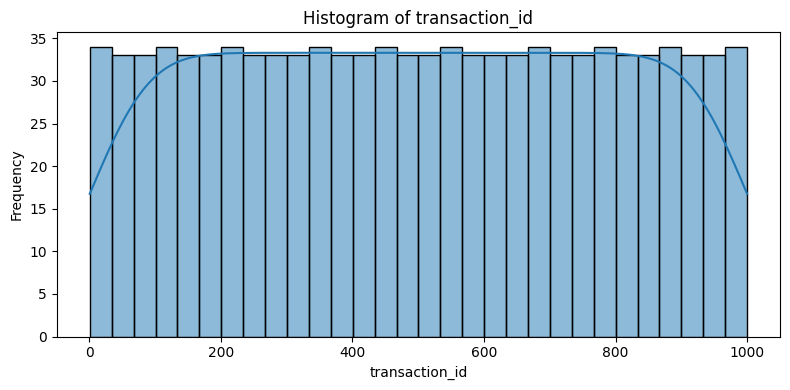

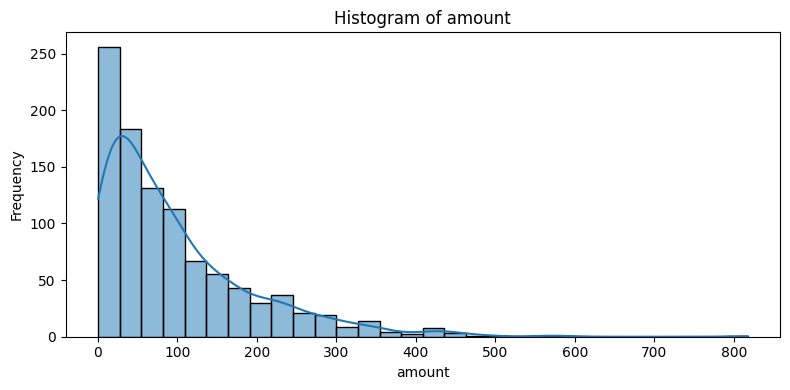

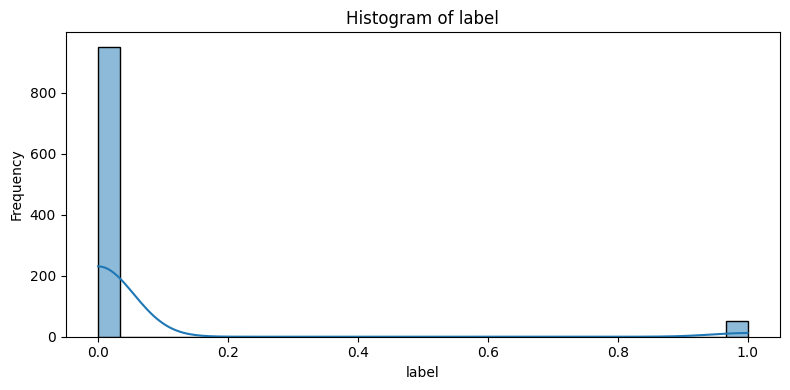

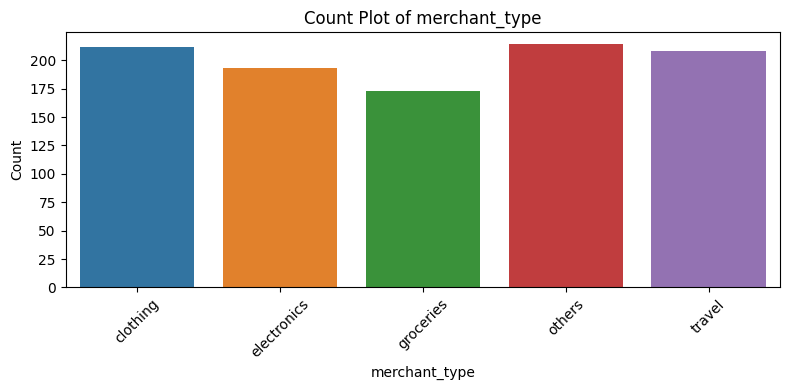

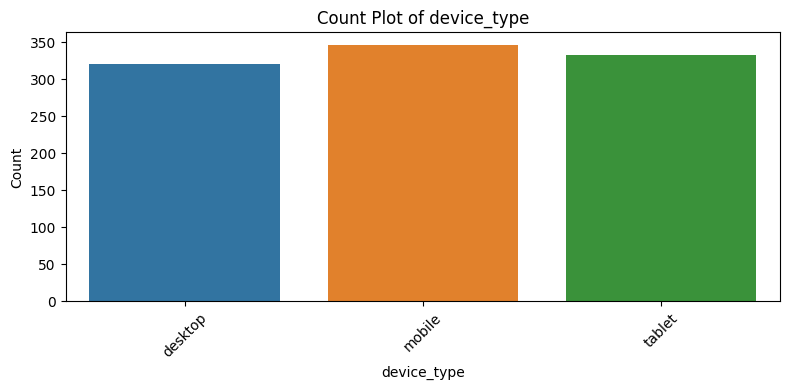

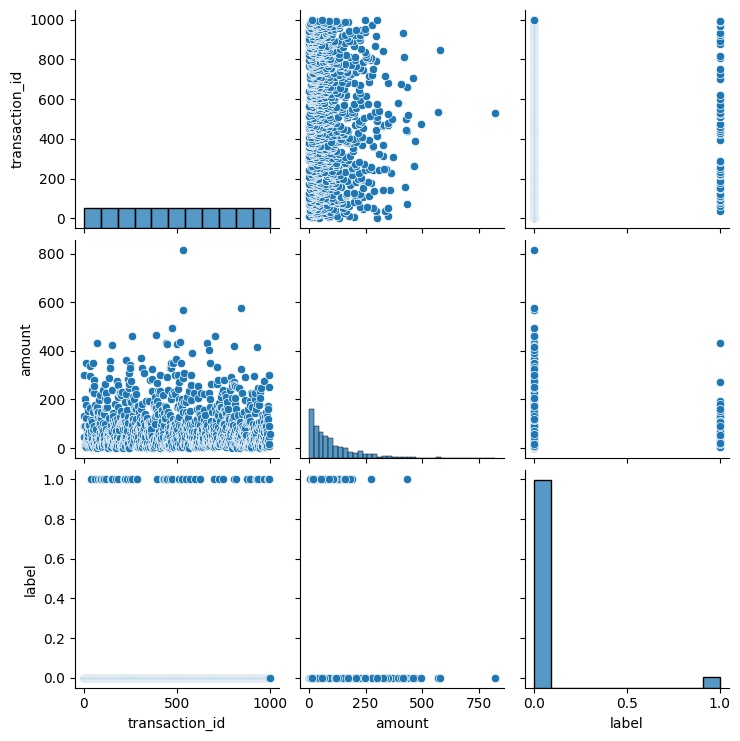

In [3]:
# Visualization: Histograms for numeric features
numeric_df = df.select_dtypes(include=[np.number])

# Plot histograms for each numeric column
for col in numeric_df.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(numeric_df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Plot correlation heatmap if there are 4 or more numeric columns
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()

# Visualization: Count plots (Pie chart equivalent) for categorical features using countplot
categorical_cols = ['merchant_type', 'device_type']
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[col])
    plt.title(f'Count Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualization: Pairplot for numeric columns if applicable
if numeric_df.shape[1] > 1:
    sns.pairplot(numeric_df)
    plt.show()

## Predictor Development and Evaluation

Given that fraud detection is a classic binary classification problem, we construct a predictor using a RandomForestClassifier. We then evaluate the model performance with accuracy score, confusion matrix, and ROC curve. Keep in mind that during model development, verifying the integrity of file paths (as noted in previous warnings) is critical to avoid unnecessary errors.

Accuracy Score: 0.9300


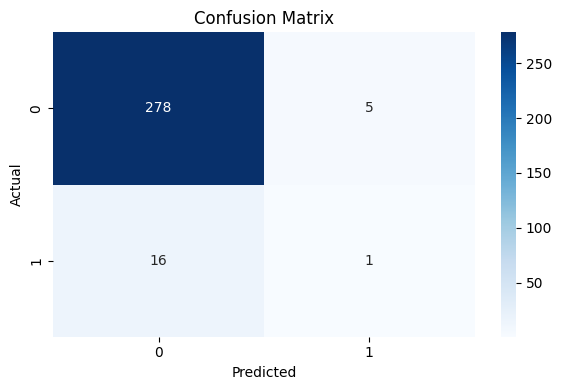

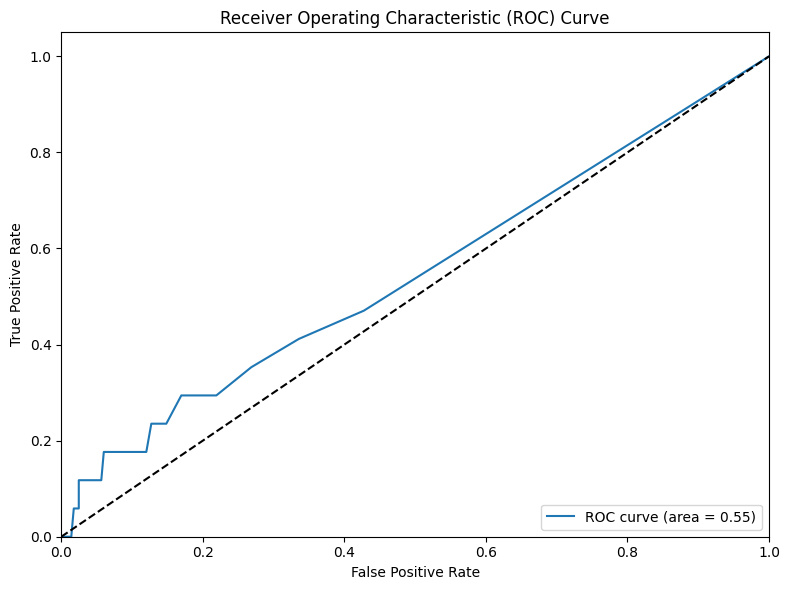

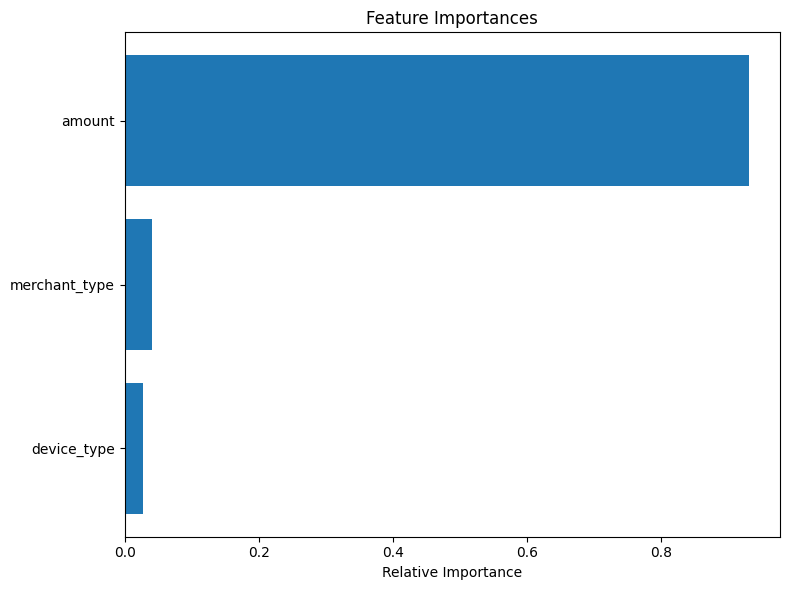

In [4]:
# Features selection
# For demonstration, we use 'amount', and encode categorical variables.
df_model = df.copy()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in ['merchant_type', 'device_type']:
    df_model[col] = le.fit_transform(df_model[col])

# Define feature matrix X and target y
X = df_model.drop(['transaction_id', 'label'], axis=1)
y = df_model['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model Evaluation: Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {accuracy:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC Curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Feature Importance (Permutation Importance could be applied; here we show the built-in importance)
importances = model.feature_importances_
features = X.columns
indices = np.argsort(importances)
plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

## Conclusion

The analysis provided robust visualizations and a sound predictive model for fraud detection. While the RandomForest classifier achieved a promising accuracy, further tuning and exploring additional algorithms could improve performance. Future analysis might include advanced feature engineering, cross-validation, or testing with other classification models. 

Overall, this notebook demonstrates a systematic approach in exploring, cleaning, visualizing, and modeling data. If you found this exploration insightful, an upvote would be most appreciated.